In [26]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [27]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [28]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [29]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [30]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd, generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / (n_embd + n_hidden) ** 0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias] # b1]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [31]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # Construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch in X,Y
    
    # Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate embeddings
    # linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    # ---------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch norm
    # update running batch norm stats
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ---------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer logits
    loss = F.cross_entropy(logits, Yb) # cross-entropy loss function
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update weights
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0924
  20000/ 200000: 2.5404
  30000/ 200000: 2.0025
  40000/ 200000: 2.1796
  50000/ 200000: 1.8179
  60000/ 200000: 2.0529
  70000/ 200000: 2.3218
  80000/ 200000: 2.3995
  90000/ 200000: 2.0109
 100000/ 200000: 2.2177
 110000/ 200000: 2.3830
 120000/ 200000: 1.6960
 130000/ 200000: 1.9017
 140000/ 200000: 2.2374
 150000/ 200000: 2.0510
 160000/ 200000: 2.1043
 170000/ 200000: 2.4598
 180000/ 200000: 2.1027
 190000/ 200000: 2.0730


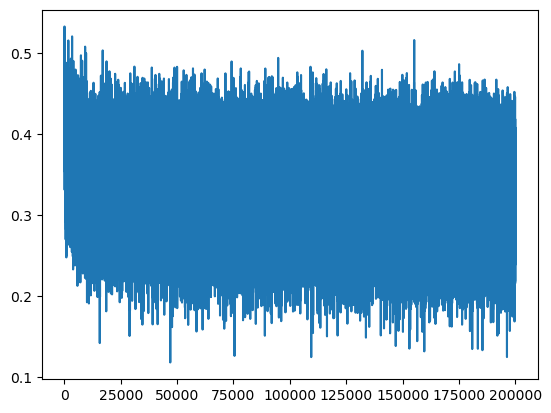

In [32]:
plt.plot(lossi)

In [25]:
b1.grad

In [33]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate embeddings into (N, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch norm
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0929791927337646
val 2.1249091625213623


In [1]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size # start with . . .
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # 1, block_size, n_embd
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
        hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # batch norm
        h = torch.tanh(hpreact) # 1, n_hidden
        logits = h @ W2 + b2 # 1, vocab_size
        probs = F.softmax(logits, dim=-1) # 1, vocab_size
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # If we sample the '.' token, break
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))

NameError: name 'torch' is not defined

In [59]:
# Summary

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with gradient descent)
        self.gamma = torch.ones(dim) # gamma is the deviation
        self.beta = torch.zeros(dim) # beta is the mean
        # buffers (updated with moving averages)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normaliz to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embd = 10 # the dimensional of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)
    
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [60]:
# same optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # Construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch in X,Y
    
    # Forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concatenate vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # cross-entropy loss function
    
    # Backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i > 1000:
        break



      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.22%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%


Text(0.5, 1.0, 'activation distribution')

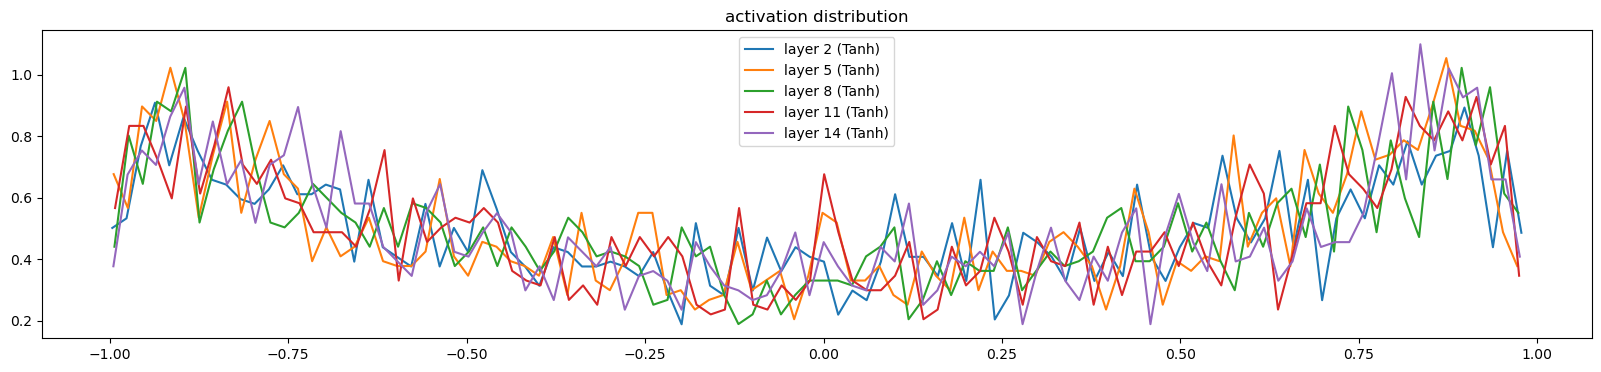

In [61]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # skip the last layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (torch.abs(t) > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.63, grad mean -0.00, grad std 0.00
layer 5 (      Tanh): mean +0.01, std 0.64, grad mean -0.00, grad std 0.00
layer 8 (      Tanh): mean -0.00, std 0.64, grad mean +0.00, grad std 0.00
layer 11 (      Tanh): mean +0.00, std 0.64, grad mean -0.00, grad std 0.00
layer 14 (      Tanh): mean -0.00, std 0.64, grad mean +0.00, grad std 0.00


Text(0.5, 1.0, 'gradient distribution')

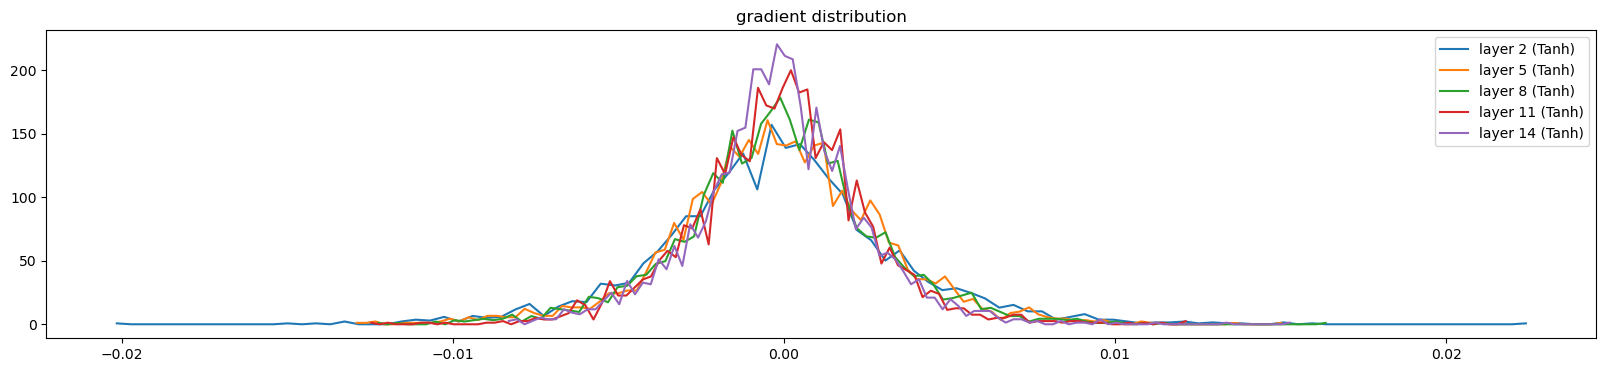

In [62]:
# visualize gradients
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # skip the last layer
    if isinstance(layer, Tanh):
        t = layer.out
        g = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, grad mean %+.2f, grad std %.2f' % (i, layer.__class__.__name__, t.mean(), t.std(), g.mean(), g.std()))
        hy, hx = torch.histogram(g, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.198688e-03 | grad:data ratio 8.190329e-03
weight  (30, 100) | mean -0.000195 | std 7.650421e-03 | grad:data ratio 2.447706e-02
weight (100, 100) | mean -0.000097 | std 6.207595e-03 | grad:data ratio 3.712889e-02
weight (100, 100) | mean +0.000015 | std 5.561930e-03 | grad:data ratio 3.297635e-02
weight (100, 100) | mean +0.000008 | std 5.220613e-03 | grad:data ratio 3.110158e-02
weight (100, 100) | mean +0.000029 | std 4.829172e-03 | grad:data ratio 2.876375e-02
weight  (100, 27) | mean -0.000014 | std 9.281235e-03 | grad:data ratio 5.568829e-02


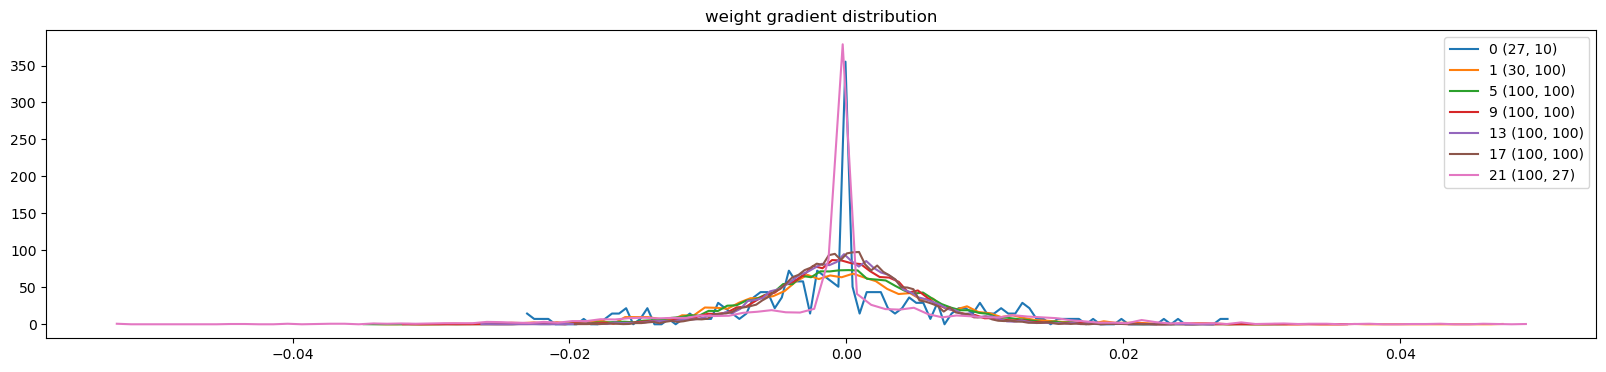

In [63]:
# visualize weight gradient distribution
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('weight gradient distribution')

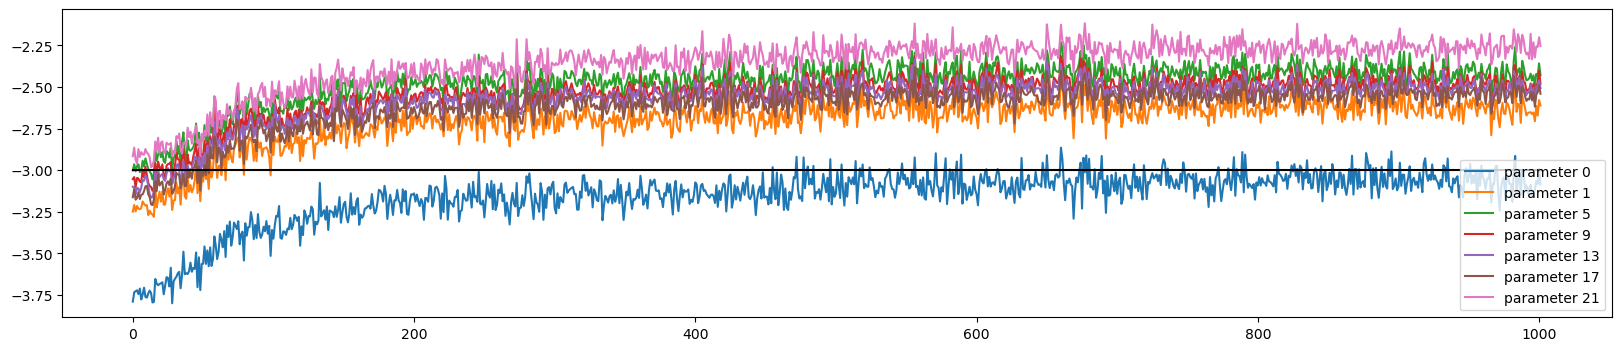

In [64]:
# ratio of learning update to data
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('parameter %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)